In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time,math,csv
import itertools
import collections

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# geo
import fiona
import shapely.geometry
from rtree import index

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

#migration-lib
sys.path.append(os.path.join(os.getcwd(),"migration-lib"))
import MigrationDataUSA
import MigrationModels
import EvaluationMethods

## Load counties for which we have migration data

In [2]:
migration_counties = []
f = open("data/migration/largestCountyIntersection_2004_2014.txt")
for line in f.read().strip().split("\n"):
    migration_counties.append(line)
f.close()

## Load flooding per block group

In [3]:
def load_bg_flood_data(slr_amount):
    f = open("data/slr_%dft_bg_intersection.csv" % (slr_amount), "r")
    header_line = f.readline().strip().split(",")
    data = {}
    for line in f:
        line = line.strip()
        if line != "":
            parts = line.split(",")
            geoid = parts[0]
            total_area = int(parts[1])
            flooded_area = int(parts[2])
            percent_flooded = float(parts[3])
            data[geoid] = percent_flooded
    f.close()
    
    return data

In [4]:
flood_data = [
    load_bg_flood_data(i) for i in range(7)
]

In [5]:
len(flood_data)

7

## Load population per block group

In [6]:
def load_bg_population_data(year):
    f = open("data/regression_estimated_population.csv", "r")
    header_line = f.readline().strip().split(",")
    data = {}
    
    year_index = None
    for i in range(2, len(header_line)):
        if int(header_line[i]) == year:
            year_index = i
            break
    if year_index is None:
        raise ValueError("year must be between 2010 and 2100")
    
    for line in f:
        line = line.strip()
        if line != "":
            parts = line.split(",")
            geoid = parts[1]
            population = float(parts[year_index])
            data[geoid] = population
    f.close()

    return data

In [7]:
population_data = load_bg_population_data(2050)

In [8]:
len(population_data)

216330

## Load block group --> county mapping

In [9]:
f = open("data/regression_estimated_population.csv", "r")
header_line = f.readline().strip().split(",")
bg_to_county = {}
for line in f:
    line = line.strip()
    if line != "":
        parts = line.split(",")
        county_id = parts[0]
        bg_id = parts[1]
        bg_to_county[bg_id] = county_id
f.close()

block_groups = sorted(bg_to_county.keys())
counties = sorted(list(set(bg_to_county.values())))


counties_to_index = {county: i for i, county in enumerate(migration_counties)}

bg_to_county_index = {}
for k,v in bg_to_county.items():
    if v in counties_to_index:
        bg_to_county_index[k] = counties_to_index[v]
    else:
        bg_to_county_index[k] = None

## Hauer Results Implementation

In [10]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

In [11]:
# medium
medium_results_county = []
previously_affected_population = {bg_id: 0.0 for bg_id in block_groups}
for i in range(len(medium_years)):
    print(i)
    population_data = load_bg_population_data(medium_years[i])
    
    affected_population_county = np.zeros((len(migration_counties)))
    population_county = np.zeros((len(migration_counties)))
    
    affected_population = {}
    for bg_id in block_groups:
        affected_area = 0.0
        if flood_data[i][bg_id] != 1.0:
            affected_area = (float(flood_data[i+1][bg_id]) - float(flood_data[i][bg_id]) ) / (1.0 - flood_data[i][bg_id])
        affected_population[bg_id] = previously_affected_population[bg_id] + ((population_data[bg_id] - previously_affected_population[bg_id]) * affected_area)
    
    for bg_id in block_groups:
        county_index = bg_to_county_index[bg_id]
        if county_index is not None:
            affected_population_county[county_index] += affected_population[bg_id]
            population_county[county_index] += population_data[bg_id]
    
    medium_results_county.append((population_county,affected_population_county))
    previously_affected_population = affected_population

0
1
2


In [12]:
# high
high_results_county = []
previously_affected_population = {bg_id: 0.0 for bg_id in block_groups}
for i in range(len(high_years)):
    print(i)
    population_data = load_bg_population_data(high_years[i])
    
    affected_population_county = np.zeros((len(migration_counties)))
    population_county = np.zeros((len(migration_counties)))
    
    affected_population = {}
    for bg_id in block_groups:
        affected_area = 0.0
        if flood_data[i][bg_id] != 1.0:
            affected_area = (float(flood_data[i+1][bg_id]) - float(flood_data[i][bg_id]) ) / (1.0 - flood_data[i][bg_id])
        affected_population[bg_id] = previously_affected_population[bg_id] + ((population_data[bg_id] - previously_affected_population[bg_id]) * affected_area)
    
    for bg_id in block_groups:
        county_index = bg_to_county_index[bg_id]
        if county_index is not None:
            affected_population_county[county_index] += affected_population[bg_id]
            population_county[county_index] += population_data[bg_id]
    
    high_results_county.append((population_county,affected_population_county))
    previously_affected_population = affected_population

0
1
2
3
4
5


In [13]:
sum_medium_results = []
sum_high_results = []

for i in range(len(medium_years)):
    sum_medium_results.append(medium_results_county[i][1].sum())
    
for i in range(len(high_years)):
    sum_high_results.append(high_results_county[i][1].sum())

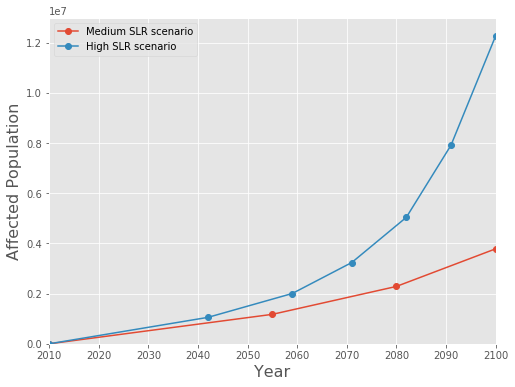

In [14]:
plt.figure(figsize=(8,6))

plt.plot([2010] + medium_years, [0] + sum_medium_results, label="Medium SLR scenario", marker="o")
plt.plot([2010] + high_years, [0] + sum_high_results, label="High SLR scenario", marker="o")

plt.legend(loc="best")

plt.xlim([2010,2100])
plt.ylim([0, 1.3e7])

plt.xlabel("Year", fontsize=16)
plt.ylabel("Affected Population", fontsize=16)

plt.show()
plt.close()

In [15]:
f = open("data/affected_population_medium.csv","w")
f.write("County FIPS,")
for i,year in enumerate(medium_years):
    f.write("Total Population %d,Affected Population %d," % (year, year))
f.write("\n")
for county_idx in range(len(migration_counties)):
    f.write("%s," % (migration_counties[county_idx]))
    for i,year in enumerate(medium_years):
        f.write("%f," % (medium_results_county[i][0][county_idx]))
        f.write("%f," % (medium_results_county[i][1][county_idx]))
    f.write("\n")
f.close()

In [16]:
f = open("data/affected_population_high.csv","w")
f.write("County FIPS,")
for i,year in enumerate(high_years):
    f.write("Total Population %d,Affected Population %d," % (year, year))
f.write("\n")
for county_idx in range(len(migration_counties)):
    f.write("%s," % (migration_counties[county_idx]))
    for i,year in enumerate(high_years):
        f.write("%f," % (high_results_county[i][0][county_idx]))
        f.write("%f," % (high_results_county[i][1][county_idx]))
    f.write("\n")
f.close()